## Experiment: single species plasmodium perplexities

__Mail Henrik 14/08/2020__: We realized that _P. vivax_ has a relatively high GC content, compared to _P. falciparum_ and most others.  
We split the test set per species, and evaluate the perplexities of the fine-tuned model.

In [2]:
import sys
sys.path.append('..')
from models.awd_lstm import ProteinAWDLSTMForLM, ProteinAWDLSTMConfig
from tape import TAPETokenizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from tape.datasets import pad_sequences

from tqdm import tqdm_notebook as tqdm


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Split the data

In [13]:
test_data = pd.read_csv('plasmodium_test_full.tsv', sep = '\t')
test_data.head()

organisms = test_data['Organism'].value_counts()
organisms = organisms[organisms>10]

### Evaluation: do in `species_level_perplexities.py` and load results

In [45]:
df = pd.read_csv('perplexities_perspecies.csv')#.set_index('Unnamed: 0')
df['species_name'] = df['Unnamed: 0'].apply(lambda x: " ".join(x.split()[:2]))

In [68]:
gc_dict = {
 'Plasmodium berghei': 24.98, 
 'Plasmodium chabaudi':26.64 , 
 'Plasmodium coatneyi':41.64,
 'Plasmodium cynomolgi': 40.4, 
 'Plasmodium falciparum': 24.99,
 'Plasmodium fragile': 41.68,
 'Plasmodium gaboni': 23.95,
 'Plasmodium gallinaceum': 19.2991,
 'Plasmodium gonderi': 27.1,
 'Plasmodium inui':42.95,
 'Plasmodium knowlesi': 40.23,
 'Plasmodium malariae': 29.08,
 'Plasmodium ovale': 32.11,
 'Plasmodium reichenowi': 25.36,
 'Plasmodium relictum': 18.40,
 'Plasmodium sp.': 29.93, #average from gc_contents.xlsx
 'Plasmodium vinckei': 26.3,
 'Plasmodium vivax': 44.7,
 'Plasmodium yoelii': 25.05}

In [94]:
df_summary = df[df['n_sequences']>100].groupby('species_name').mean()
df_summary = df[df['n_sequences']>100].groupby('species_name').agg({'perplexity':'mean', 'n_sequences' :  'sum'})
df_summary['percent_gc'] = pd.Series(gc_dict)

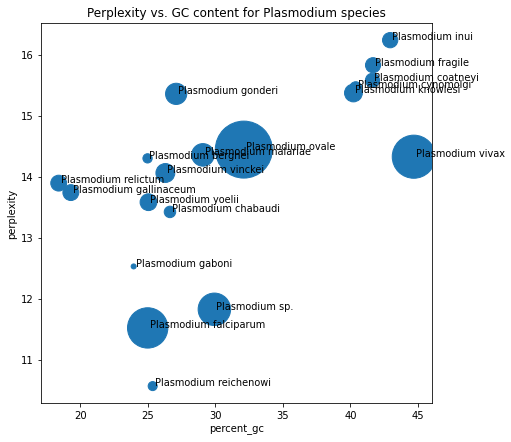

In [191]:
ax = df_summary.plot.scatter(x = 'percent_gc', y= 'perplexity', s = ((df_summary['n_sequences']/df_summary['n_sequences'].min())*5)**2, figsize = (7,7))
#ax = df_summary.plot.scatter(x = 'percent_gc', y= 'perplexity', c = 'n_sequences', colormap = 'viridis')
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+0.14, point['y'], str(point['val']), size = 9.8)

label_point(df_summary['percent_gc'], df_summary['perplexity'], df_summary.index.to_series(), ax)

plt.title('Perplexity vs. GC content for Plasmodium species')
plt.show()

In [135]:
df_train = pd.read_csv('plasmodium_train_full.tsv', sep = '\t')
organisms = df_train['Organism'].value_counts()

df_train = pd.DataFrame(organisms).reset_index()
df_train['species_name'] = df_train['index'].apply(lambda x: " ".join(x.split()[:2]))

df_train = df_train.groupby('species_name').sum()

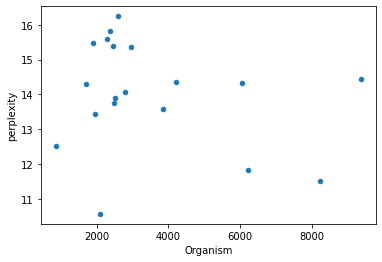

In [157]:
df_summary.join(df_train).plot.scatter(x = 'Organism', y= 'perplexity')

In [173]:
df_summary.join(df_train)

,perplexity,n_sequences,percent_gc,Organism
species_name,,,,
Plasmodium berghei,14.305871,782.0,24.9800,1712
Plasmodium chabaudi,13.428181,966.0,26.6400,1951
Plasmodium coatneyi,15.585667,1188.0,41.6400,2288
Plasmodium cynomolgi,15.463419,1010.0,40.4000,1883
Plasmodium falciparum,11.527152,3396.0,24.9900,8222
Plasmodium fragile,15.832470,1271.0,41.6800,2364
Plasmodium gaboni,12.534863,421.0,23.9500,867
Plasmodium gallinaceum,13.744866,1338.0,19.2991,2494
Plasmodium gonderi,15.362884,1786.0,27.1000,2967


In [181]:
pd.read_csv('plasmodium_train_full.tsv', sep = '\t').groupby('Organism').count()['Entry name'].sort_values()

Organism
Plasmodium atheruri                                           1
Plasmodium falciparum (isolate FC27 / Papua New Guinea)       1
Plasmodium falciparum (isolate fcm17 / Senegal)               1
Plasmodium falciparum (isolate thtn / Thailand)               1
Plasmodium knowlesi (strain nuri)                             1
                                                           ... 
Plasmodium sp. DRC-Itaito                                  2655
Plasmodium gonderi                                         2967
Plasmodium ovale curtisi                                   3458
Plasmodium ovale wallikeri                                 4032
Plasmodium malariae                                        4198
Name: Entry name, Length: 77, dtype: int64

,Unnamed: 0,Entry,Entry name,Gene names,Organism,Length,Taxonomic lineage (GENUS),Sequence
0,12030165,A0A023PZP0,A0A023PZP0_PLAYO,NaN,Plasmodium yoelii yoelii,1779,Plasmodium,MKVIGLLFSFVFFAIKCKSETIEVYNDLIQKLEKLESLSVEGLELF...
1,9467224,A0A024A091,A0A024A091_PLAFA,serca,Plasmodium falciparum,1227,Plasmodium,MEEVIKNAHTYDVEDVLKFLDVNKDNGLKNEELDDRRLKYGLNELE...
2,7198026,A0A024UVM3,A0A024UVM3_PLAFA,PFFVO_06223,Plasmodium falciparum Vietnam Oak-Knoll (FVO),18,Plasmodium,MNFYKTKEHLKRKNLKQF
3,7186940,A0A024UVQ7,A0A024UVQ7_PLAFA,PFFVO_06190,Plasmodium falciparum Vietnam Oak-Knoll (FVO),338,Plasmodium,MKIHYYKLLLFSLPLNILAHNKNKPYIIPRYTPTVTSRGLSECDIQ...
4,7104045,A0A024UVR4,A0A024UVR4_PLAFA,PFFVO_06195,Plasmodium falciparum Vietnam Oak-Knoll (FVO),94,Plasmodium,MIFLILIQINIKYSRLVCGIIIKLILYFINYKKICYFKIYILGYLF...
...,...,...,...,...,...,...,...,...
66932,9784423,X2CLY0,X2CLY0_9APIC,MSP3G,Plasmodium cynomolgi,393,Plasmodium,MKRIWSFSLFIFFLSFYMLQHGVVKNVTNKRRKPNIRNDPPLDGNS...
66933,12424189,X2CM20,X2CM20_9APIC,MSP3I,Plasmodium inui,179,Plasmodium,MHCLRMRQFLRISIFISLLNLYMEKNGIVCREIQNVTKTNLRNGTP...
66934,12432322,X2CM97,X2CM97_9APIC,MSP3I,Plasmodium inui,178,Plasmodium,MHCLRMRQFLRISIFISLLNLYMEKNGTVCGEIQNVTETNLRNGTP...
66935,6872274,X2CMP5,X2CMP5_PLAGO,MSP3G PGO_102830,Plasmodium gonderi,332,Plasmodium,MKQIWSTIFFIFFLNIFALEYNVVNNEIINLRNSGARNNVTSDNKS...
